In [1]:
import pandas as pd
import numpy as np
from numpy import inf
from datetime import date,datetime, timedelta

import os
import requests
from io import StringIO

import sqlite3

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.2f}'.format

con = sqlite3.connect('/path/****.db')
cursor = con.cursor()

# 고객 행동 데이터 load

In [2]:
df = pd.concat([
    pd.read_csv('/path/0_인앱이벤트.csv')
    ,pd.read_csv('/path/1_인앱이벤트.csv')
])

# appsflyer 데이터 load

In [3]:
sql = """
SELECT
`Advertising ID`
,`Customer User ID`
,`Media Source`
,`Campaign`
,`Site ID`
,`Campaign ID`
,`Channel`
,`Adset`
,`Adset ID`
,`Ad`
,`Ad ID`
,`Match Type`
,`Install Time`
,`Platform`

FROM ****
"""

cursor.execute(sql)
columns = [description[0] for description in cursor.description]
df_non_organic_installs = pd.DataFrame(cursor.fetchall(),columns=columns)

sql = """
SELECT
`Advertising ID`
,`Customer User ID`
,`Media Source`
,`Campaign`
,`Site ID`
,`Campaign ID`
,`Channel`
,`Adset`
,`Adset ID`
,`Ad`
,`Ad ID`
,`Install Time`
,`Platform`

FROM ****
"""

cursor.execute(sql)
columns = [description[0] for description in cursor.description]
df_organic_installs = pd.DataFrame(cursor.fetchall(),columns=columns)

In [4]:
#### af 데이터 정리
df_install = pd.concat([
    df_non_organic_installs
    ,df_organic_installs
])

df_install['Advertising ID'] = np.where(
    df_install['Advertising ID'].notnull()
    ,df_install['Advertising ID']
    ,df_install['Customer User ID']
)

print(df_install.shape)
df_install.rename(columns={'Advertising ID':'****'},inplace=True)
df_install = df_install.drop_duplicates('****')
df_install['Media Source'] = df_install['Media Source'].fillna('Organic')

(282430, 14)


In [6]:
df_install_ = df_install[[
    'uuid'
    ,'Media Source'
    ,'Campaign'
    ,'Adset'
    ,'Ad'
]]

# 이벤트 로그에 af media 속성 merge

In [7]:
df_merge = pd.merge(
    df
    ,df_install_
    ,'left'
    ,on='****'
    ,suffixes=('','_y')
)

In [8]:
print(df.shape)
print(df_merge.shape)

(3481705, 10)
(3481705, 14)


In [9]:
df_merge['Media Source'].fillna('NotInApps',inplace=True)

# install dataframe 분리

In [11]:
df_merge_ = df_merge.drop_duplicates('****id')

In [12]:
df_merge_['type'] = 'install'
df_merge_['created_at'] = df_merge_['user_created_at']

In [13]:
df_merge_.shape[0] + df_merge.shape[0]

3751886

In [ ]:
# 인앱 이벤트 로그 dataframe 에는 install log가 없으므로, 분리한 isntall df를 concat 함

In [14]:
df_merge__ = pd.concat([
    df_merge
    ,df_merge_
])

df_merge__['Media Source'].replace(
    'restricted'
    ,'Facebook Ads'
,inplace=True)

In [15]:
df_merge__.shape

(3751886, 14)

# 필요 컬럼 생성

In [16]:
df_merge__['created_date'] = pd.to_datetime(df_merge__['****'].astype(str).str[:10])
df_merge__['****_created_date'] = pd.to_datetime(df_merge__['****'].astype(str).str[:10])
#### 가입 후 이벤트 발생 경과일 install to event
df_merge__['i2e'] = (df_merge__['created_date'] - df_merge__['****']).dt.days
df_merge__['DayofWeek'] = df_merge__['****'].dt.dayofweek
df_merge__['i2e_by_7'] = np.where(
    df_merge__['i2e']<=6
    ,df_merge__['i2e']
    ,(df_merge__['i2e']/7).astype(int)*7
)

df_merge__['week'] = (((pd.to_datetime('2022-08-20') - pd.to_datetime(df_merge__['****'].astype(str).str[:10])).astype(str).str[:-24].astype(int)/7)+0.9999).astype(int)
df_merge__['week(date)'] = (pd.to_datetime('2022-08-13') - pd.to_timedelta(((df_merge__['week']-1)*7).astype(str)+' days'))

df_merge__['event_week'] = (((pd.to_datetime('2022-08-20') - pd.to_datetime(df_merge__['****'].astype(str).str[:10])).astype(str).str[:-24].astype(int)/7)+0.9999).astype(int)
df_merge__['event_week(date)'] = (pd.to_datetime('2022-08-13') - pd.to_timedelta(((df_merge__['event_week']-1)*7).astype(str)+' days'))

df_merge__['****_created_hour'] = pd.to_datetime(df_merge__['****_created_at']).dt.hour

# 구매 고객 data load

In [17]:
df_buyer = pd.read_excel('/path/구매유저.xlsx')

df_buyer = df_buyer[
    (df_buyer['****'].notnull())
][[
    '상태'
    ,'****'
]].rename(columns={'****':'****_id','상태':'is_bought'})

# 인앱 채팅 data load

In [18]:
df_chat = pd.read_excel('/path/채팅 로그.xlsx',sheet_name='User data')
df_chat_type = pd.read_excel('/path/채팅 로그(타입분류완료).xlsx')

df_user_id = df_chat[[
    'id'
    ,'name'
]]

df_chat_type = pd.merge(
    df_chat_type
    ,df_user_id.rename(columns={'id':'personId'})
    ,'left'
    ,on='personId'
    ,suffixes=('','_y')
)

In [20]:
df_merge__ = pd.merge(
    df_merge__.sort_values(['****_id','****'])
    ,df_buyer
    ,'left'
    ,on='****'
    ,suffixes=('','_y')
)

In [21]:
df_chat_type.type = df_chat_type.type.astype('category')
sorter =[
    '****
    ,'****'
    ,'****'
    ,'****'
    ,'****'
    ,'****'
    ...
]

df_chat_type.type.cat.set_categories(sorter,inplace=True)

# 이벤트 로그에 채팅 유형 merge

In [22]:
df_merge__ = pd.merge(
    df_merge__
    ,df_chat_type.sort_values(['type']).drop_duplicates('name')[[
        'type'
        ,'name'
    ]].rename(columns={'name':'****'})
    ,'left'
    ,on='****'
    ,suffixes=('','_y')
)

In [24]:
df_merge__['****'] = np.append(np.array([df_merge__['****'][0]]),df_merge__['****'].values[:-1]).tolist()

In [25]:
# 가입 후 이벤트 발생 경과일 컬럼 추가
df_merge__['ctct'] = (pd.to_datetime(df_merge__['****'])-pd.to_datetime(df_merge__['****'])).dt.total_seconds().fillna(-9999).astype(int)

# 10분 (600s) 기준 세션 구분

In [27]:
user_id_list = list(df_merge__['id'].values)
ctct_list = list(df_merge__['ctct'].values)

In [28]:
result = []
first_id = 17
num = 1

for x,y in zip(user_id_list,ctct_list):
    if x == first_id:
        if y < 600:
            result.append(num)
            first_id = x
        else:
            num = num + 1
            first_id = x
            result.append(num)
    else:
        first_id = x
        num = 1
        result.append(num)

In [29]:
df_merge__['session'] = result

In [30]:
#### 데이터 처리 완료 ####

# 가입 후 7일 내 세션 수 dataframe

In [ ]:
df_session = df_merge__[
    (df_merge__['i2e']>=0)
    &(df_merge__['i2e']<=6)
].pivot_table(
    index=[
        '****'
        ,'****'
        ,'****'
        ,'****'
    ]
    ,values='session'
    ,aggfunc='max'
).reset_index().sort_values('session')

# 가입 후 7일 내 특정 이벤트 발생 수 dataframe

In [380]:
df_car_detail = df_merge__[
    (df_merge__['i2e']>=0)
    &(df_merge__['i2e']<=6)
    &(df_merge__['type']=='****')
].pivot_table(
    index='****'
    ,columns='type'
    ,values='****'
    ,aggfunc='count'
).fillna(0).reset_index()#.sort_values('app_open')

In [382]:
df_result = pd.merge(
    df_session
    ,df_car_detail
    ,'left'
    ,on='user_id'
    ,suffixes=('','_y')
)

# 거래 완료 data merge

In [383]:
df_result = pd.merge(
    df_result
    ,df_merge__[
        (df_merge__['type']=='install')
        &(df_merge__['is_bought']=='****')
    ][['****','is_bought']]
    ,'left'
    ,on='****'
    ,suffixes=('','_y')
)

In [384]:
df_result[
    (df_result['is_bought'].notnull())
].shape

(60, 7)

In [385]:
df_result[
    (df_result['****'].notnull())
].shape

(150177, 7)

In [386]:
df_result['****'].fillna(0,inplace=True)

# 컬럼 추가

In [387]:
df_result['is_bought_'] = np.where(
    df_result['is_bought'] == '****'
    ,True,False
)

In [389]:
df_result['more_than_10_sessions'] = np.where(
    df_result['session']>=10,True,False
)

df_result['more_than_10_****'] = np.where(
    df_result['****']>=10,True,False
)

# 엑셀 저장, 성과 보조 지표 개발 끝

In [393]:
df_result[
#    (df_result['more_than_10_sessions']==True)
    (df_result['more_than_10_car_detail']==True)
    &(
        (df_result['Media Source']=='****')
        |(df_result['Media Source']=='****')
        |(df_result['Media Source']=='****')
        |(df_result['Media Source']=='****')
        |(df_result['Media Source']=='****')
    )
].pivot_table(
    index=['Media Source']
    ,values='****'
    ,aggfunc='count'
).reset_index().sort_values(['user_id'],ascending=False).to_excel('/path/*****.xlsx')

# 시각화

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

X = df_result[
    (df_result['is_bought_']==True)
]['session'].values

Y = df_result[
    (df_result['is_bought_']==True)
]['****'].values

X_ = df_result['session']
Y_ = df_result['****']

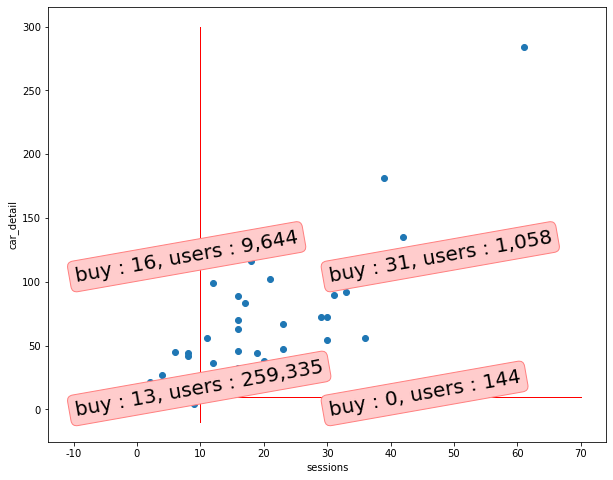

In [372]:
plt.scatter(X, Y)
plt.plot([-10, 70], [10, 10], 'k-', lw=1, color='red')
plt.plot([10, 10], [-10, 300], 'k-', lw=1, color='red')
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('sessions')
plt.ylabel('****')

plt.text(30, 100, "buy : 31, users : 1,058", size=20, rotation=10.,
#         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

plt.text(-10, 100, "buy : 16, users : 9,644", size=20, rotation=10.,
#         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

plt.text(-10, -5, "buy : 13, users : 259,335", size=20, rotation=10.,
#         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

plt.text(30, -5, "buy : 0, users : 144", size=20, rotation=10.,
#         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

plt.show()

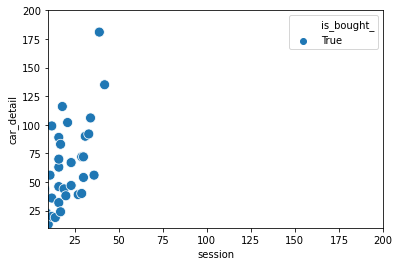

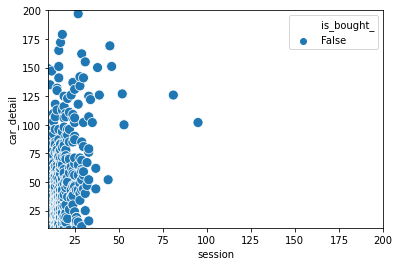

In [257]:
sns.scatterplot(x='session'
                ,y='****'
                ,hue='is_bought_'
                ,style='is_bought_'
                ,s=100
                ,data=df_data[(df_data['is_bought_']==True)])
plt.xlim([10, 200])
plt.ylim([10, 200])
plt.show()

sns.scatterplot(x='session'
                ,y='****'
                ,hue='is_bought_'
                ,style='is_bought_'
                ,s=100
                ,data=df_data[(df_data['is_bought_']==False)])
plt.xlim([10, 200])
plt.ylim([10, 200])
plt.show()

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [174]:
df_result_ = df_result[[
    'is_bought_'
    ,'session'
    ,'****'
]]

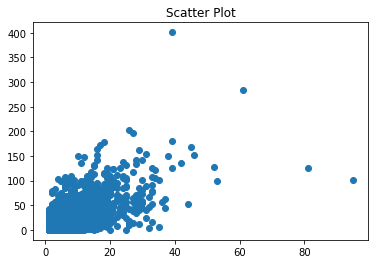

In [62]:
plt.title("Scatter Plot")
plt.scatter(df_result_['session'],df_result_['car_detail'])
plt.show()